# Model Implementation: LSTM

## Libraries

In [ ]:
pip install contractions

In [ ]:
import keras_tuner as kt
import nltk
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from preprocessing import *
from utils import *

In [ ]:
nltk.download('stopwords')

## Data Uploading

In [ ]:
# Load dataset

df_train  = pd.read_csv('C:/Users/naomi/emotion-detection-txa/Pretrained_Model Implementation/labeled_data_reddit_text_yangswei_85.csv')

In [19]:
df_train.head()

,subreddit,link_id,parent_id,created_utc,upvotes,text,predictions
0,remotework,1fy22yp,t3_1fy22yp,2024-10-07 13:03:07,17,Oh how offices have changed the movie office s...,joy
1,remotework,1fy22yp,t3_1fy22yp,2024-10-07 11:38:45,79,Oh how offices have changed when i was in the ...,sadness
2,remotework,1fy22yp,t3_1fy22yp,2024-10-07 11:41:54,66,Oh how offices have changed you were also sexu...,anger
3,remotework,1fy22yp,t3_1fy22yp,2024-10-07 16:17:46,11,Oh how offices have changed overwhelmingly mos...,sadness
4,remotework,1fy22yp,t3_1fy22yp,2024-10-07 11:43:37,28,Oh how offices have changed this isn't even cl...,joy


## Preprocessing

In [ ]:
#Preprocess training data

df_train['text'].apply(preprocess).to_frame()

# Tokenize and pad training data

padded_sequences, train_vocabulary, vocab_size = tokenize_and_pad(df_train[['text']])


### Encoding

In [ ]:
# Set training data

train_data = padded_sequences

#Encoding labels for keras

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['predictions'])
num_classes = len(set(y_encoded))
y_encoded_cat = to_categorical(y_encoded, num_classes=num_classes)

### Splitting

In [ ]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(train_data, y_encoded_cat, test_size=0.2, random_state=42)

## The Model

### Tuning

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [64, 128, 256])))
    model.add(LSTM(hp.Int('lstm_units1', min_value=64, max_value=256, step=64), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('lstm_units2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  
    executions_per_trial=2,  
    directory='tuner_results',
    project_name='emotion_classification'
)

c:\Users\naomi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
tuner.search(X_train, y_train, epochs=7, validation_split=0.2, batch_size=32)

Trial 25 Complete [02h 24m 13s]
val_accuracy: 0.6335034370422363

Best val_accuracy So Far: 0.6374291777610779
Total elapsed time: 1d 11h 14m 21s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

### Implementation

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=3,          # Detiene el entrenamiento después de 3 épocas sin mejora
    restore_best_weights=True  # Restaura los pesos del modelo a la mejor época
)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(96))     
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 448s 353ms/step - accuracy: 0.5966 - loss: 1.1772 - val_accuracy: 0.6026 - val_loss: 1.1389
Epoch 2/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 424s 338ms/step - accuracy: 0.5962 - loss: 1.1610 - val_accuracy: 0.6026 - val_loss: 1.1403
Epoch 3/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 425s 339ms/step - accuracy: 0.5970 - loss: 1.1590 - val_accuracy: 0.6020 - val_loss: 1.1382
Epoch 4/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 414s 330ms/step - accuracy: 0.6190 - loss: 1.0948 - val_accuracy: 0.7149 - val_loss: 0.8365
Epoch 5/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 408s 326ms/step - accuracy: 0.7469 - loss: 0.7581 - val_accuracy: 0.7784 - val_loss: 0.6366
Epoch 6/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 415s 331ms/step - accuracy: 0.8339 - loss: 0.4899 - val_accuracy: 0.8117 - val_loss: 0.5346
Epoch 7/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 398s 317ms/step - accuracy: 0.8980 - loss: 0.3113 - val_accuracy: 0.8172 - val_loss: 0.5380
Epoch 8/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 394s 314ms/step - ac

In [ ]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

697/697 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.8115 - loss: 0.5376
Test Accuracy: 0.8113


In [34]:
y_pred_prob = model.predict(X_test)

y_pred = np.argmax(y_pred_prob, axis=1)

y_test_1d = np.argmax(y_test, axis=1)
y_test_1d

697/697 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step


array([2, 2, 0, ..., 0, 2, 2], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print(classification_report(y_test_1d, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      3332
           1       0.60      0.55      0.57      1097
           2       0.88      0.89      0.88     13447
           3       0.66      0.59      0.63       164
           4       0.78      0.74      0.76      3955
           5       0.86      0.73      0.79       294

    accuracy                           0.81     22289
   macro avg       0.74      0.70      0.72     22289
weighted avg       0.81      0.81      0.81     22289



In [ ]:
y_test_decoded = label_encoder.inverse_transform(y_test_1d)  
y_pred_decoded = label_encoder.inverse_transform(y_pred)

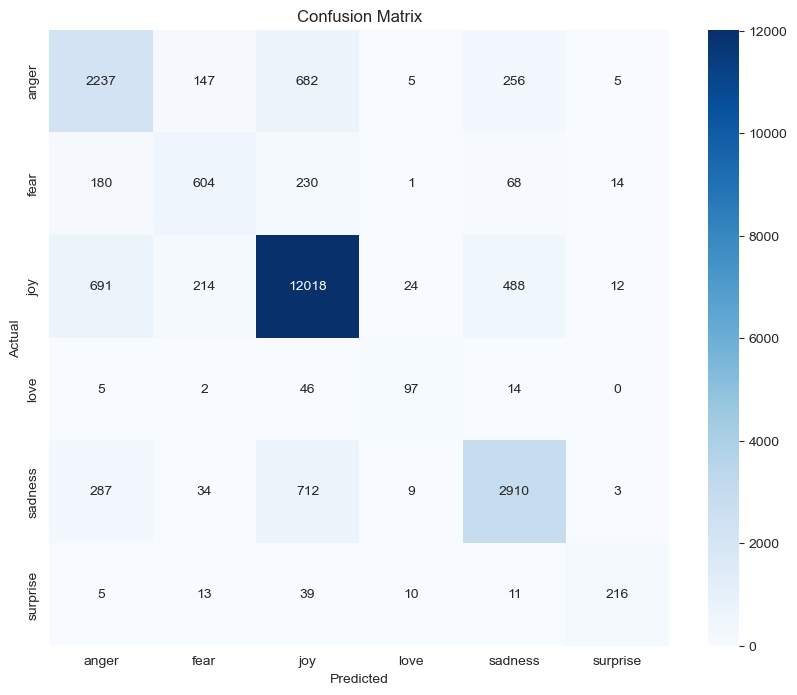

In [40]:
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [41]:
print(classification_report(y_test_decoded, y_pred_decoded))

              precision    recall  f1-score   support

       anger       0.66      0.67      0.66      3332
        fear       0.60      0.55      0.57      1097
         joy       0.88      0.89      0.88     13447
        love       0.66      0.59      0.63       164
     sadness       0.78      0.74      0.76      3955
    surprise       0.86      0.73      0.79       294

    accuracy                           0.81     22289
   macro avg       0.74      0.70      0.72     22289
weighted avg       0.81      0.81      0.81     22289

